In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages',
                     '../src']
sys.prefix = '/home/joaom/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

In [1]:
from pathlib import Path
home = str(Path.home())
import sys
sys.path =  [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']

In [2]:
import awswrangler as wr
import pandas as pd
import boto3

In [3]:
from h3 import h3
from shapely import wkt
import geojson
from copy import deepcopy

In [251]:
def wkt_to_geojson(s):
    return geojson.Feature(geometry=wkt.loads(s), properties={}).geometry

def to_wkt(x):
    x = x + [x[0]]
    return "polygon" + str(x).replace("], [", ",").replace(", ", " ").replace(
        "[", "("
    ).replace("]", ")")

def _get_cell(gjson, resolution):
    
    temp = pd.Series(list(h3.polyfill(gjson.values[0], resolution, True)), name='id').to_frame()
    temp['resolution'] = resolution
    temp['wkt'] = temp['id'].apply(lambda x: to_wkt(h3.h3_to_geo_boundary(x, True)))
    temp['id_parent'] = temp['id'].apply(lambda x: h3.h3_to_parent(x, res=7))
    temp['group'] = (temp.index / 100).astype(int)
    return temp

def get_cells(gjson):
    
    coarse_resolutions = [3]
    for resolution in coarse_resolutions:
        
        temp = _get_cell(gjson, resolution)
        
        if len(temp) > 100000: 
            continue
        else:
            coarse = deepcopy(temp)
            break 
            
#     return pd.concat([_get_cell(gjson, 10), coarse])
    
    return coarse


In [121]:
metadata = pd.read_csv('http://tiny.cc/idb-traffic-metadata')


In [164]:
def reescale(s, factor=1.1):
    
    s = wkt.loads(s)
    
    s = affinity.scale(s, factor, factor)
    
    return s.to_wkt()
    
    


In [322]:
metadata = pd.read_sql_query(
    "select region_slug, region_shapefile_wkt from spd_sdv_waze_corona.dev_metadata_metadata_prepare where region_slug = 'country_brazil'",
    conn
)

In [323]:
metadata

,region_slug,region_shapefile_wkt
0,country_brazil,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117..."


In [325]:
a = metadata['region_shapefile_wkt'].iloc[0]

In [337]:
def _bigger_polygon(poly):
    return max([(i.to_wkt(), i.area) for i in list(wkt.loads(poly))], key=lambda x: x[1])[0]

'POLYGON ((-73.9830630000000014 -7.5347340000000003, -73.9511719999999997 -7.3574830000000002, -73.6956250000000068 -7.3114759999999999, -73.7998620000000045 -7.1170949999999999, -73.7104599999999976 -6.8401899999999998, -73.1352260000000030 -6.5104610000000003, -73.2364680000000021 -6.0360399999999998, -72.9589830000000035 -5.6563600000000003, -72.8186699999999973 -5.1026670000000003, -71.9073230000000052 -4.5157780000000001, -70.9356980000000021 -4.3843180000000004, -70.7596989999999977 -4.1589289999999997, -70.3228079999999949 -4.1420620000000001, -70.1919400000000024 -4.3617910000000002, -69.9413550000000015 -4.2892370000000000, -69.3952340000000021 -1.1255480000000000, -69.6249069999999932 -0.7466710000000000, -69.6078320000000019 -0.5007980000000000, -70.0432279999999992 -0.1899790000000000, -70.0470679999999959 0.5631210000000000, -69.4800240000000002 0.7357680000000000, -69.1156330000000025 0.6448400000000000, -69.2449390000000022 1.0565519999999999, -69.8426580000000001 1.0727

In [324]:
a = (metadata[metadata['region_slug'].isin(['country_brazil'])]
     .set_index('region_slug')['region_shapefile_wkt'] 
     .apply(reescale)
     .apply(wkt_to_geojson)
     .reset_index()
     .groupby('region_slug')['region_shapefile_wkt'].apply(get_cells)      
     .reset_index().drop('level_1', 1))                  

Exception: Only Polygon GeoJSON supported

In [311]:
!wc -l ../data/support_tables/all_cities/brazil_cities.csv

5568 ../data/support_tables/all_cities/brazil_cities.csv


In [291]:
cities = pd.read_csv('../data/support_tables/all_cities/municipalities.csv', sep='|')

In [313]:
city_grid = (
    pd.read_csv('../data/support_tables/all_cities/brazil_cities.csv', sep='|')
    .set_index('code_muni')['geometry']
    .apply(lambda x: wkt.loads(x).convex_hull.to_wkt())
    .apply(wkt_to_geojson)
    .reset_index()
    .groupby('code_muni')['geometry'].apply(get_cells)
    .reset_index()
    .drop(['level_1', 'id_parent'], 1)
    .rename(columns={'code_muni': 'id', 'id': 'id_parent'})
    .assign(region_slug='country_brazil', resolution=10) 
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


In [308]:
pd.concat([
    city_grid,
    a
])

,id,id_parent,resolution,wkt,group,region_slug
0,1.10002e+06,838b18fffffffff,10,polygon((-61.84666938784618 -13.29071268579978...,0,country_brazil
1,1.10002e+06,838a22fffffffff,10,polygon((-63.18618178992387 -9.351420356810426...,0,country_brazil
2,1.10005e+06,838a34fffffffff,10,polygon((-60.846750778233904 -11.7398638932109...,0,country_brazil
3,1.10006e+06,838b1efffffffff,10,polygon((-60.946141864818664 -13.9258880085124...,0,country_brazil
4,1.10011e+06,838b0bfffffffff,10,polygon((-65.15017429804568 -11.47212367111249...,0,country_brazil
...,...,...,...,...,...,...
771,838adcfffffffff,0,3,polygon((-61.198553234044326 1.090818369541872...,7,country_brazil
772,838b59fffffffff,0,3,polygon((-69.67030935159386 -7.175899809952629...,7,country_brazil
773,838a1afffffffff,0,3,polygon((-60.551790546795544 -5.06851297338195...,7,country_brazil
774,838aa9fffffffff,0,3,polygon((-59.59967440219072 -4.551179229352630...,7,country_brazil


In [73]:
config = dict(
    athena_database='spd_sdv_waze_corona',
    bucket='iadbprod-public-stata-as-a-service',
    prefix='spd-sdv-omitnik-waze/corona',
    raw_table='grid',
    name='test_grid',
    slug='dev',
    mode='overwrite'
)

res = wr.s3.to_parquet(
    df=a,
    path="s3://{bucket}/{prefix}/{slug}/{raw_table}/{name}".format(**config),
    dataset=True,
    database=config["athena_database"],
    table="{slug}_{raw_table}_{name}".format(**config),
    mode=config["mode"],
    partition_cols=["region_slug"],
    boto3_session=boto3.Session(region_name="us-east-1"),
)

In [136]:
b = metadata[metadata['region_slug'].isin(['country_brazil'])]

In [143]:
b = wkt.loads(b['region_shapefile_wkt'].iloc[0])

In [144]:
from shapely import affinity    metadata = get_data_from_athena(
        "select region_slug, region_shapefile_wkt from "
        f"{config['athena_database']}.{config['slug']}_metadata_metadata_prepare "
        "where region_slug = 'country_brazil'",
        config,
    )

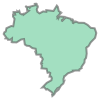

In [162]:
affinity.scale(b, 2, 2)

In [74]:
sys.path.append('../')
from src import utils
conn = utils.connect_athena(path='../configs/athena.yaml')

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  athena_config = yaml.load(open(path, "r"))


In [338]:
for region_slug in ['bogota', 'santiago', 'riodejaneiro', 'lima']:
    print(region_slug)
    df = pd.read_sql_query(f"select * from spd_sdv_waze_corona.dev_grid_grid_hourly_index where region_slug = '{region_slug}'", conn)
    df.to_csv(f'~/shared/spd-sdv-omitnik-waze/corona/grid-data/{region_slug}_grid_hourly_tci_perc_change.csv', index=False)

bogota
santiago
riodejaneiro
lima


In [114]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)   
from h3 import h3
import folium

In [169]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=3, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [168]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 2) # lat, lng, hex resolution                                                                                                        
m = visualize_hexagons(list(a['id']))
display(m)